In [4]:
import numpy as np
import os
import glob
import seaborn as sns
import pandas as pd

file_savedir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/ukraine'
file_readdir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_orig/Ukraine'

# Define a function to categorize hours into morning, midday, and evening
def tod(hour):
    if hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    else:
        return "evening"
    
def make_date_col(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    return df

# Define weights for each hour
default_weights = {"morning": 0.3, "midday": 0.5, "evening": 0.2}

# select dates of interest
def select_dates(df):
    df = df[df['Date'] <= '1850-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df

no days with less than 3 obs, yay!


/tmp/ipykernel_2302828/1157243019.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ta = df.groupby('Date').apply(


Text(0, 0.5, 'Temperature [°C]')

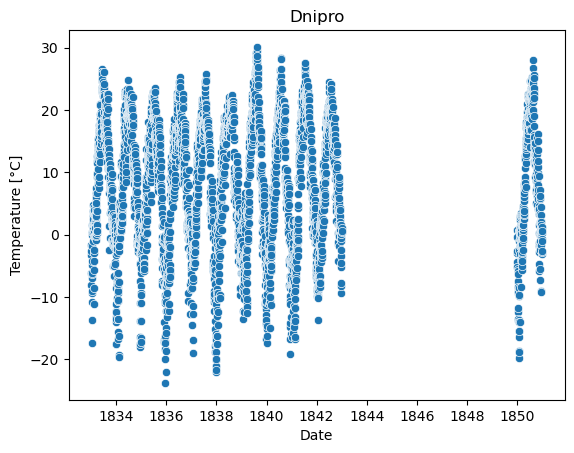

In [25]:
df = pd.read_csv(f'{file_readdir}/Dnipro.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
df['P'] = pd.to_numeric(df['P'])
df['T'] = pd.to_numeric(df['T'])
df = df.replace(-999.9,np.NaN)             # replace -999.9 by NaN
df = df.dropna(subset=['T', 'P'], how='all') # drop if both NaN

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
unvalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(unvalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['T'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum()
)
df_ta = pd.DataFrame({'TMP2m': df_ta})
df_ta = df_ta.reset_index()
df_ta

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title(r'Dnipro')
sns_plot.set_ylabel('Temperature [°C]')
